In [487]:
from collections import defaultdict
class Solution:
    def atmostk(self,n,k,nums):
        l=0
        r=0
        map=defaultdict(int)
        ans=0
        while r<n:
            map[nums[r]]+=1
            while len(map)>k:
                map[nums[l]]-=1
                if map[nums[l]]==0:
                    del map[nums[l]]
                l+=1
            
            ans+=r-l+1
            r+=1
        return ans
    def subarraysWithKDistinct(self, nums: list[int], k: int) -> int:
        return self.atmostk(len(nums),k,nums)-self.atmostk(len(nums),k-1,nums)

In [489]:
Solution().subarraysWithKDistinct(nums=[1,2,3,1,2], k=2)

4

## GPT (Generative Pre-trained Transformer)
In this notebook, I will replicate the implementations by Andrej Karpathy's video "Let's build GPT: from scratch, in code, spelled out" ([youtube](https://youtu.be/kCc8FmEb1nY)).

### Goal
Through building a character level model to write shakespeare style works, learn transformers.


### Approach

- First we load up the data and build a mapping of character to index and index to character for encoding. There are other encodings such as bytepair encoding ex. google's SentencePiece and openAI's BPE libraries. These encode chunks of characters based on frequency of appearing together. Vocabulary size is much larger than number of characters (~50k) but then the context window length is smaller. This is a tradeoff.
- Then we learn a bigram model on the character level. `P(c_next=cn|c=ci)` this is a multinomial over characters (vocab_sz x vocab_sz) matrix.
- Then we discuss how attention is implemented with vectorisation.

In [469]:
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    target_version=black.TargetVersion.PY310,
)

In [470]:
from IPython.display import display, HTML, clear_output

display(HTML("<style>.container { width:100% !important; }</style>"))


from dataclasses import dataclass, field
import typing as t
import itertools as it
import collections as c
import gc
import json
from copy import deepcopy
import math
import time
import functools as ft
import numpy as np
import random
from tqdm.notebook import tqdm
import heapq
import torch
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import torch.utils.tensorboard as tb

plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.size"] = 14

In [471]:
%%bash
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
ls -lh input.txt

-rw-r--r--  1 vispers  staff   1.1M 19 Jan 11:10 input.txt


In [4]:
INPUT_FL = "input.txt"
BLOCK_SZ = 8

## Load data and build mappings

In [5]:
with open(INPUT_FL, encoding="utf-8") as infile:
    input_txt = infile.read()
vocab = sorted(set(input_txt))
vocab_sz = len(vocab)
ctoix = {char: ix for ix, char in enumerate(vocab)}
ixtoc = {ix: char for ix, char in enumerate(vocab)}
print(vocab)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
print(f"Num characters: {len(input_txt)}")
print()
print(input_txt[:1000])

Num characters: 1115394

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not

### Convert the input txt into a data matrix
n = len(txt) \
dim(X) = dim(Y) = (n-block_sz, block_sz)

We create a sliding window and make each letter's output the next letter.

In [358]:
def txt_to_data(input_txt, ctoix, block_size):
    Xs, Ys = [], []
    input_len = len(input_txt)
    input_ixes = encode(txt=input_txt, ctoix=ctoix)
    for i in range(0, input_len - block_size, block_size):
        Xs.append(input_ixes[i : i + block_size])
        Ys.append(input_ixes[i + 1 : i + block_size + 1])
    return torch.tensor(Xs), torch.tensor(Ys)


def encode(txt, ctoix):
    return [ctoix[char] for char in txt]


def decode(x, ixtoc, to_replace_nl=False):
    txt = "".join(ixtoc[xi.item()] for xi in x)
    if to_replace_nl:
        txt = txt.replace("\n", "<N>")
    return txt

In [359]:
encoded_input = encode(txt=input_txt, ctoix=ctoix)

In [360]:
X, Y = txt_to_data(input_txt=input_txt, ctoix=ctoix, block_size=BLOCK_SZ)
X.shape, Y.shape

(torch.Size([139424, 8]), torch.Size([139424, 8]))

### Util function to iterate over a random batch

In [361]:
def iter_dataset(Xs, Ys, batch_sz, num=None):
    num = num or np.inf
    i = 0
    n = Xs.shape[0]
    while i < num:
        i += 1
        batch_ixes = torch.randint(n, (batch_sz,))
        yield Xs[batch_ixes], Ys[batch_ixes]


def print_batch_txt(Xbatch, Ybatch, ixtoc):
    """Print the input batch to text for verification"""
    for xi, yi in zip(Xbatch, Ybatch):
        print(
            decode(xi, ixtoc, to_replace_nl=True)
            + " --> "
            + decode(yi, ixtoc, to_replace_nl=True)
        )

In [362]:
for Xbatch, Ybatch in iter_dataset(X, Y, batch_sz=4, num=2):
    print_batch_txt(Xbatch, Ybatch, ixtoc=ixtoc)
    print()

 it conf --> it confo
ot be dr --> t be dru
hearts,  --> earts, a
but I mi --> ut I mig

you were --> ou were 
tis now  --> is now s
nd, my b --> d, my bo
hath bee --> ath been



## Training
### Split train test

In [363]:
def split_data(X, Y, train_frac=0.8, val_frac=0.1, to_shuffle=True):
    num_samples = X.shape[0]
    train_ix = int(num_samples * train_frac)
    val_ix = train_ix + int(num_samples * val_frac)
    ixes = list(range(num_samples))
    if to_shuffle:
        random.shuffle(ixes)
    train_ixes, val_ixes, test_ixes = (
        ixes[:train_ix],
        ixes[train_ix:val_ix],
        ixes[val_ix:],
    )
    print(f"Num train: {train_ix:,}\nnum validation: {val_ix-train_ix:,}")
    return {
        "train": (X[train_ixes], Y[train_ixes]),
        "val": (X[val_ixes], Y[val_ixes]),
        "test": (X[test_ixes], Y[test_ixes]),
    }

In [364]:
# we don't want any test data
data_splits = split_data(
    X=X, Y=Y, train_frac=0.9, val_frac=0.2, to_shuffle=False
)
data_splits["test"]

Num train: 125,481
num validation: 27,884


(tensor([], size=(0, 8), dtype=torch.int64),
 tensor([], size=(0, 8), dtype=torch.int64))

In [365]:
Xtrain, Ytrain = data_splits["train"]
Xval, Yval = data_splits["val"]

## Training

In [366]:
torch.manual_seed(1337);

### Train loop

In [369]:
def train_model(
    model,
    Xtrain,
    Ytrain,
    batch_sz,
    num_iters,
    optimizer,
    eval_loss_fn,
    losses: dict[str, list],  # train -> [], val -> []
    loss_calc_freq=100,
):
    for i, (Xi, Yi) in (
        pbar := tqdm(
            enumerate(
                iter_dataset(Xs=X, Ys=Y, num=num_iters, batch_sz=batch_sz)
            ),
            total=num_iters,
        )
    ):
        probas, loss = model(X=Xi, target=Yi)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        # Metric tracking
        if i % loss_calc_freq == 0:
            loss_msg = ""
            for split, loss in eval_loss_fn(model=model).items():
                losses[split].append(loss)
                loss_msg += f"{split} loss: {loss:.4f} "
            pbar.set_description(loss_msg)


def plot_loss(losses, avg_win=1, loss_calc_freq=1):
    plt.figure(figsize=(10, 5))
    for i, (split, split_losses) in enumerate(losses.items(), start=1):
        n = avg_win * (len(split_losses) // avg_win)
        plt.grid(True)
        plt.plot(
            np.arange(0, n, avg_win) * loss_calc_freq,
            torch.tensor(split_losses[:n])
            .view(-1, avg_win)
            .mean(dim=1)
            .detach()
            .numpy(),
            label=split,
            linewidth=2,
        )
    plt.title(f"Loss vs iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()


@torch.no_grad()
def eval_loss(model, data_splits, eval_sz):
    model.eval()
    out = {}
    for split in ["train", "val"]:
        X, Y = data_splits[split]
        Xbatch, Ybatch = next(iter_dataset(Xs=X, Ys=Y, batch_sz=eval_sz))
        # fwd, loss = model(X, target)
        out[split] = model(X=Xbatch, target=Ybatch)[1].item()
    model.train()
    return out


def calc_loss(Ypred, Ytrue):
    """
    Ypred dim: Batch_size x block_sz x vocab_sz
    Ytrue dim: Batch_size x block_sz
    """
    return F.cross_entropy(input=_flatten_y(Ypred), target=Ytrue.view(-1))


def _flatten_y(Y):
    B, T, C = Y.shape
    return Y.view(B * T, C)


@torch.no_grad()
def calc_split_loss(model, data_splits, split):
    model.eval()
    X, Ytrue = data_splits[split]
    loss = model(X=X, target=Ytrue).item()
    model.train()
    return loss


train_nll = ft.partial(calc_split_loss, data_splits=data_splits, split="train")
val_nll = ft.partial(calc_split_loss, data_splits=data_splits, split="val")
eval_loss_fn = ft.partial(eval_loss, data_splits=data_splits, eval_sz=5000)

### Bigram model

In [370]:
@dataclass(eq=False)
class BigramModel(nn.Module):

    vocab_sz: int
    embed: nn.Embedding = field(init=False)

    def __post_init__(self):
        super().__init__()
        vocab_sz = self.vocab_sz
        self.embed = nn.Embedding(
            num_embeddings=vocab_sz, embedding_dim=vocab_sz
        )
        # make predictions less confident at the beginning so that all
        # classes about equal probability.
        self.embed.weight.data = self.embed.weight * 0.01

    def forward(self, X, target=None):
        """Returns the forward pass and NLL loss"""
        out = self.embed(X)
        if target is None:
            return out, None
        else:
            loss = calc_loss(Ypred=out, Ytrue=target)
            return out, loss
        return out

In [371]:
bigram_model = BigramModel(vocab_sz=vocab_sz)

In [372]:
Xbatch.shape, bigram_model(Xbatch)[0].shape

(torch.Size([4, 8]), torch.Size([4, 8, 65]))

#### Generate examples from untrained model

In [373]:
def gen_examples(
    model: nn.Module,
    max_len: int,
    start_ix_tns: torch.Tensor = None,
    num_examples: int = None,
) -> torch.Tensor:
    """Generates examples from the model.

    Either
    * start_ix_tns will pass in the first token for each word
    * or we use num_examples to arrive at the number of examples and
        we always begin with a newline character.
    """
    assert not (
        start_ix_tns is None and num_examples is None
    ), "Either pass first token or pass num examples"
    # B x T x C
    if start_ix_tns is None:
        start_ix_tns = torch.zeros(num_examples, 1, dtype=torch.int)
    examples = start_ix_tns.clone()
    for i in range(max_len):
        # B x C
        logits, loss = model(examples[:, -1])
        # B x C
        probas = F.softmax(logits, dim=1)
        # B x 1
        next_ix = torch.multinomial(probas, num_samples=1)
        examples = torch.concat((examples, next_ix), axis=1)
    return examples


def print_examples(
    model: nn.Module,
    start_ix_tns: torch.Tensor,
    max_len: int,
    ixtoc: dict,
    num_examples: int = None,
    to_replace_nl=False,
) -> str:
    examples = gen_examples(
        model=model,
        start_ix_tns=start_ix_tns,
        max_len=max_len,
        num_examples=num_examples,
    )
    for ex in examples:
        print("".join(decode(ex, ixtoc=ixtoc, to_replace_nl=to_replace_nl)))
        print("-----------------------------------------------------------")

In [374]:
print_examples(
    model=bigram_model,
    max_len=100,
    # assumes start token is newline char
    start_ix_tns=None,
    ixtoc=ixtoc,
    num_examples=3,
)


ZJTEov nk3gW&:!i
MbubLXOU
YOWNDEKJ:CiNe
&u-jdRT$ZeTNXiYFT',vq.PkznV-cU&din,-RVUBPqmVka anN?bZ3vdVG
!
-----------------------------------------------------------

bwWLSZCGE:qKqJgwjTExLw?JGcnw$-sOjtB&lHOmvY,z FZqeglzIQ:iCLGC cqDe3eYHhPT3hF?iQNxLfH'nWrISPV
McFnLpAT
-----------------------------------------------------------

OTcMa&?n3FkY;PFkgzH3jeD pnmVeFXsj-pNpl3xoLxAjbJputedU;qNB
ogz: XtXXBkkvc
JJ
SegsiGUrJmI;LqgRjhb-hgZM
-----------------------------------------------------------


In [375]:
Xbatch, Ybatch = next(iter_dataset(Xtrain, Ytrain, batch_sz=100))
print(f"Initial CE loss should be roughly {-np.log(1/vocab_sz):.4f}")
bigram_model(X=Xbatch, target=Ybatch)[1]

Initial CE loss should be roughly 4.1744


tensor(4.1745, grad_fn=<NllLossBackward0>)

In [378]:
bigram_model = BigramModel(vocab_sz=vocab_sz)
bigram_opt = torch.optim.AdamW(params=bigram_model.parameters(), lr=1e-2)
losses = {"train": [], "val": []}
loss_calc_freq = 1000

In [380]:
train_model(
    model=bigram_model,
    Xtrain=Xtrain,
    Ytrain=Ytrain,
    batch_sz=128,
    num_iters=30_000,
    optimizer=bigram_opt,
    loss_calc_freq=loss_calc_freq,
    losses=losses,
    eval_loss_fn=eval_loss_fn,
)

  0%|          | 0/30000 [00:00<?, ?it/s]

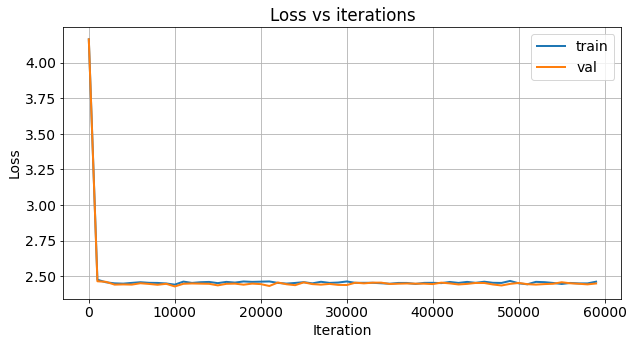

In [381]:
plot_loss(losses, loss_calc_freq=loss_calc_freq)

#### Generate examples from untrained model

In [382]:
print_examples(
    model=bigram_model,
    max_len=1000,
    # assumes start token is newline char
    start_ix_tns=None,
    ixtoc=ixtoc,
    num_examples=1,
)


Kinghour nt ldou.

MO: nchomuthis to!
Helt t t ane, h fowhiveare ard VINIO:
Alinlanssthanshat CLEDu y IFLLAnthay wized; ourauthicanca is, yeat tureeve tst
We h.
Whind aladve.
THO wig
LLINomey d home,
Ancelrea pe d mith oucosed:
Yothekieran RThe ay, and pal fif.
OK:




RWise, mood TIO:
Bu ar ave boneey no the amermeme:
ICofe s y; ome,
STre wnou hes weppl dell oty's ts
Sty

MENCA:
NGSishe h beat:
QULE:
PThy whe tior, ncortheroure irf te witis t char:
THA oe t:
ONG has
Cl yo, my! w, tinemy I ne toutare to,--fot ma fene me buill, y imisabe s the'sasollt n:

Heaind m Panelim bes bened inouided orenongintel cizer nthis wes chizeyosied he nd'satord ur pou f; wse g eservey nd ce:
Thany: sugs linsinje y oupto t co ckeris wherd I w'sheyothon

NRES:
Yef ace CLINad arh orereag tore thoweail held's.
Winond ke
S:
NNZAly thehes:
TI h w,
LO?
UNAgimuith scompanengeasto? in amat!
TONINGodeayo men'ddons im
MESke IO at, y,-tin

TERSofoundr:
R: watoveme,
Werelyod thy h. agansu y lllis'l thond wa, il II O

### Compare against analytical MLE estimate for bigram model

This would just be the statistical averages of how often each letter followed the other in the training set.

#### Build MLE matrix

In [383]:
analytical_embed = torch.zeros(vocab_sz, vocab_sz)
train_encoded_txt = encoded_input[: int(len(encoded_input) * 0.9)]
for fst_char, nxt_char in zip(train_encoded_txt, train_encoded_txt[1:]):
    analytical_embed[fst_char][nxt_char] += 1.0

##### Normalise probas

In [384]:
analytical_embed /= analytical_embed.sum(dim=1, keepdims=True)

In [385]:
def plot_embed_comparison(trained_embed, analytical_embed):
    plt.figure(figsize=(24, 8))
    plt.subplot(131)
    plt.imshow(trained_embed)
    plt.title("Bigram trained matrix")
    plt.subplot(132)
    plt.imshow(analytical_embed)
    plt.title("Analytical by computing probas")
    plt.subplot(133)
    diff_mat = trained_embed - analytical_embed
    diff_norm = diff_mat.abs().mean()
    plt.title(f"Difference matrix\nMean abs diff: {diff_norm:.5f}")
    plt.imshow(diff_mat)
    plt.colorbar();

In [386]:
trained_embed = F.softmax(
    next(bigram_model.embed.named_parameters())[1].data, dim=1
)

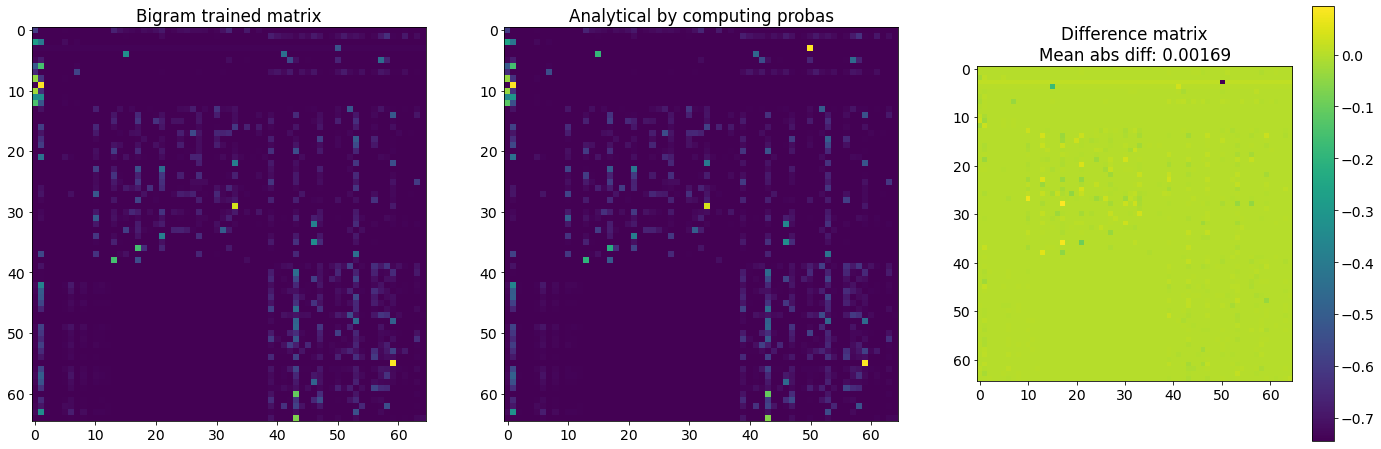

In [387]:
plot_embed_comparison(
    trained_embed=trained_embed, analytical_embed=analytical_embed
)

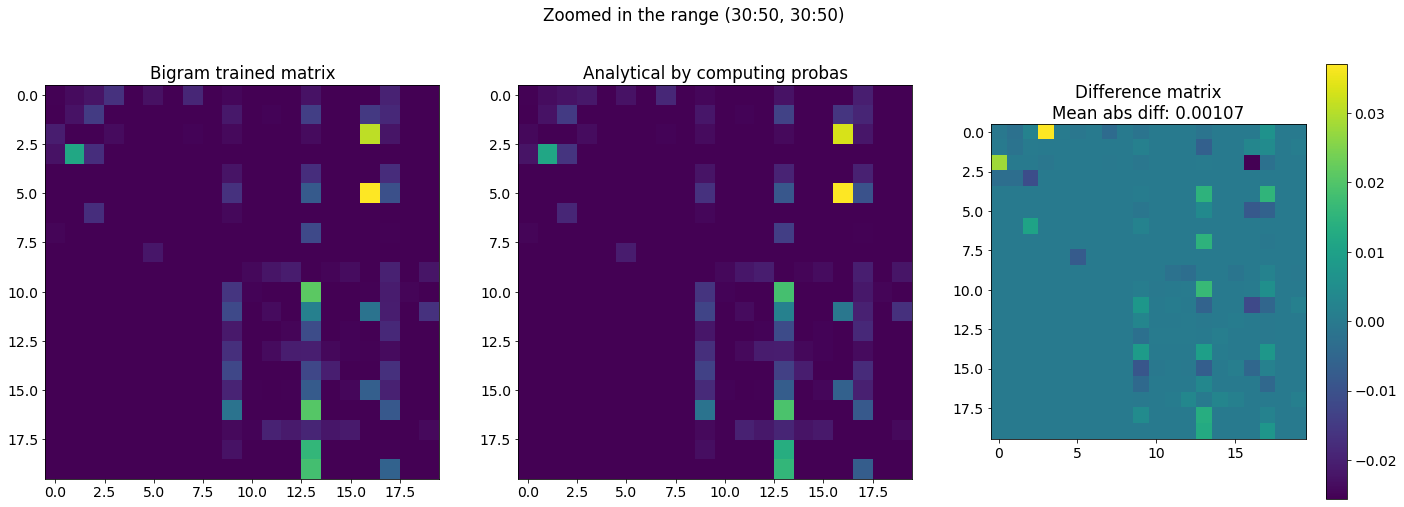

In [388]:
bix, eix = 30, 50
plot_embed_comparison(
    trained_embed=trained_embed[bix:eix, bix:eix],
    analytical_embed=analytical_embed[bix:eix, bix:eix],
)
plt.suptitle(f"Zoomed in the range ({bix}:{eix}, {bix}:{eix})");

In [393]:
Xsml = Xbatch[:5]
Xsml

tensor([[17, 26, 32, 21, 27, 10,  0, 32],
        [43, 43, 54,  1, 42, 43, 57, 54],
        [ 0,  5, 35, 46, 39, 58,  1, 51],
        [ 1, 27, 18,  1, 37, 27, 30, 23],
        [50, 63,  1, 40, 43,  1, 51, 43]])

In [410]:
Xsml = torch.arange(1, 25).view(2, 3, 4).float()

In [435]:
maskl = torch.tril(input=torch.ones(3, 3))
maskl /= maskl.sum(dim=1, keepdims=True)
print(maskl)

masku = torch.triu(input=torch.ones(3, 3))
masku /= masku.sum(dim=0, keepdims=True)
print(masku)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[1.0000, 0.5000, 0.3333],
        [0.0000, 0.5000, 0.3333],
        [0.0000, 0.0000, 0.3333]])


In [437]:
print(Xsml[0])
# T x T @ T x C
print(maskl @ Xsml[0])

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]])
tensor([[1.0000, 2.0000, 3.0000, 4.0000],
        [3.0000, 4.0000, 5.0000, 6.0000],
        [5.0000, 6.0000, 7.0000, 8.0000]])


In [438]:
# T x T @ B x T x C
# Broadcasted to B x T x T @ B x T x C
Xbow = maskl @ Xsml
Xbow[0]

tensor([[1.0000, 2.0000, 3.0000, 4.0000],
        [3.0000, 4.0000, 5.0000, 6.0000],
        [5.0000, 6.0000, 7.0000, 8.0000]])

In [454]:
B, T, C = Xsml.shape

In [462]:
Xsml[0]

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]])

In [465]:
masku

tensor([[1.0000, 0.5000, 0.3333],
        [0.0000, 0.5000, 0.3333],
        [0.0000, 0.0000, 0.3333]])

In [468]:
torch.einsum("btc,ut->btc", Xsml, masku)[0]

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]])

In [432]:
Xbow[0]

tensor([[1.0000, 2.0000, 3.0000, 4.0000],
        [3.0000, 4.0000, 5.0000, 6.0000],
        [5.0000, 6.0000, 7.0000, 8.0000]])

In [430]:
(np.random.randn(3, 3) @ np.random.randn(2, 3, 4)).shape

(2, 3, 4)

In [472]:
k = torch.arange(1, 25).view(2, 3, 4).float()
v = torch.arange(1, 25).view(2, 3, 4).float()

In [479]:
k[0] @ v[0].T

tensor([[ 846., 1078., 1310.],
        [1078., 1374., 1670.],
        [1310., 1670., 2030.]])

In [485]:
B, T, C = 2, 3, 4
query = torch.arange(1, 25).view(2, 3, 4).float()  # B x T x C
key = torch.arange(1, 25).view(2, 3, 4).float()  # B x T x C

torch.allclose(
    torch.einsum('ijk,ilk->ijl', query, key),
    query @ key.transpose(1,2)
)

True